## Manuscript figure (5): Surviving probability and ongoing activity patterns in surviving and eliminated abJGNs

### Importing libraries

In [1]:
# routine imports
import pandas as pd
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt

# setting random seeds (for reproducibility)
np.random.seed(0)
import os
os.environ['PYTHONHASHSEED'] = '0'
import random as rn
rn.seed(0)

# import umap and plotly
from umap import UMAP
import plotly.express as px

# import pycaret functions
import pycaret.classification as pyclass
import pycaret.clustering as pyclust
import pycaret.anomaly as anom
import warnings
warnings.filterwarnings('ignore')

# import sk-learn functions
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel
import imblearn as imblearn


### Loading datasets

In [2]:
# loading datasets (shall be in the same directory)
dbd2 = pd.read_excel(r'DBDs_with_low_dimension_coordination.xlsx', sheet_name = 'DBD2')
dbd4 = pd.read_excel(r'DBDs_with_low_dimension_coordination.xlsx', sheet_name = 'DBD4')
dbd6 = pd.read_excel(r'DBDs_with_low_dimension_coordination.xlsx', sheet_name = 'DBD6')
dbd8 = pd.read_excel(r'DBDs_with_low_dimension_coordination.xlsx', sheet_name = 'DBD8')
dbd10 = pd.read_excel(r'DBDs_with_low_dimension_coordination.xlsx', sheet_name = 'DBD10')

# dropping unnecessary columns and concatenating all dbds in one df, i.e. CellID_df
dbd2.drop(columns = ['Unnamed: 0', 'x', 'y', 'Unnamed: 12'], inplace = True)
dbd4.drop(columns = ['Unnamed: 0', 'x', 'y'], inplace = True)
dbd6.drop(columns = ['Unnamed: 0', 'x', 'y'], inplace = True)
dbd8.drop(columns = ['Unnamed: 0', 'x', 'y'], inplace = True)
dbd10.drop(columns = ['Unnamed: 0', 'x', 'y'], inplace = True)
CellID_df = pd.concat([dbd2, dbd4, dbd6, dbd8, dbd10])
CellID_df['type'] = CellID_df['type'].map({1: 1, 2: 0})

# dropping 'Cell ID' column for further processing of individual dbds
dbd2.drop(columns = ['Cell ID'], inplace = True)
dbd4.drop(columns = ['Cell ID'], inplace = True)
dbd6.drop(columns = ['Cell ID'], inplace = True)
dbd8.drop(columns = ['Cell ID'], inplace = True)
dbd10.drop(columns = ['Cell ID'], inplace = True)

# concatinating the datasets into main dataframe, without 'CellID'
df = pd.concat([dbd2, dbd4, dbd6, dbd8, dbd10])
df['type'] = df['type'].map({1: 1, 2: 0})
df.head()

,Surviving_Max_dRR,Surviving_Basal Tw2B ratio,Surviving_AUC/second,Surviving_Fraction of time Above 2.4,Surviving_MaxRatio,Surviving_Fraction of time Below 2.0,type,dbd
0,79.93,1.85,0.17,41.85,3.35,19.46,1,2
1,56.01,5.19,3.79,100.00,8.02,0.00,1,2
2,85.07,1.56,0.01,3.01,3.02,93.86,1,2
3,20.20,1.60,0.00,0.00,2.06,88.67,1,2
4,63.85,1.65,0.01,5.54,2.46,60.84,1,2


In [3]:
# normalizing the features in the main dataframe, to be used for umap and pycaret
norm_scaler = StandardScaler()
norm_df_PyCaret = norm_scaler.fit_transform(df.iloc[:, 0:6])

# target is the labels
target = df['type'].values

# merging the normalized dataframe and the target to have the PyCaret-like datafarme format
pycaret_df = np.concatenate((norm_df_PyCaret, target.reshape(-1,1)), axis=1)
pycaret_df = pd.DataFrame(pycaret_df)
pycaret_df.columns = df.columns[:-1]

## UMAP

In [4]:
# implementing a UMAP
reducer = UMAP(random_state = 0)
embedded = reducer.fit_transform(norm_df_PyCaret)

## Panel B: Ground truth for all DBDs

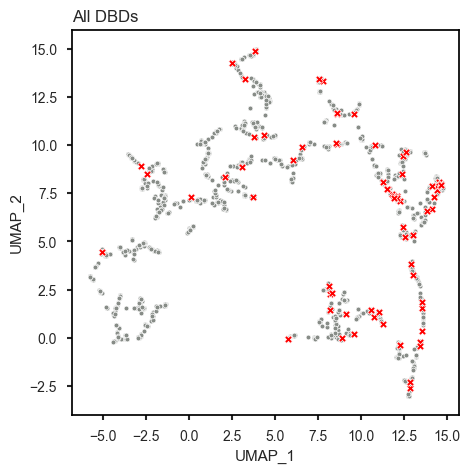

In [5]:
# setting the min and max of the plot
xmin, xmax = -6.8, 15.7 # setting min and max of plots -- derived from the manuscript figures
ymin, ymax = -4, 16 # setting min and max of plots -- derived from the manuscript figures

#### Ploting the decision boundaries
fig = plt.figure(figsize=(5, 5))
ax=fig.add_subplot(111)
ax.scatter(embedded[target == 1][:,0], embedded[target == 1][:,1], c='#878c87', s=12, edgecolor='#ffffff', linewidth=0.5)
ax.scatter(embedded[target == 0][:,0], embedded[target == 0][:,1], c='#ff0000', s=30, edgecolor='#ffffff', linewidth=0.5, marker='X')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.title('All DBDs', loc='left')
plt.grid(None)
plt.tick_params(which='major', length=3.5, width=1.5)
ax.spines[:].set_color('black')
plt.show()

## Panels A: Ground truth for each DBD

In [6]:
# DBD_df is created for plotting purposes. It contains the normalized data + labels + dbd index + x and y coordinates from UMAP
norm_df_with_dbd = norm_scaler.fit_transform(df.iloc[:, 0:6])
target_dbd = df['type'].values
dbd_values = df['dbd'].values
DBD_df = np.concatenate((norm_df_with_dbd, target_dbd.reshape(-1,1), dbd_values.reshape(-1,1), embedded), axis=1)
DBD_df = pd.DataFrame(DBD_df)
DBD_df.columns = list(df.columns) + ['x', 'y']

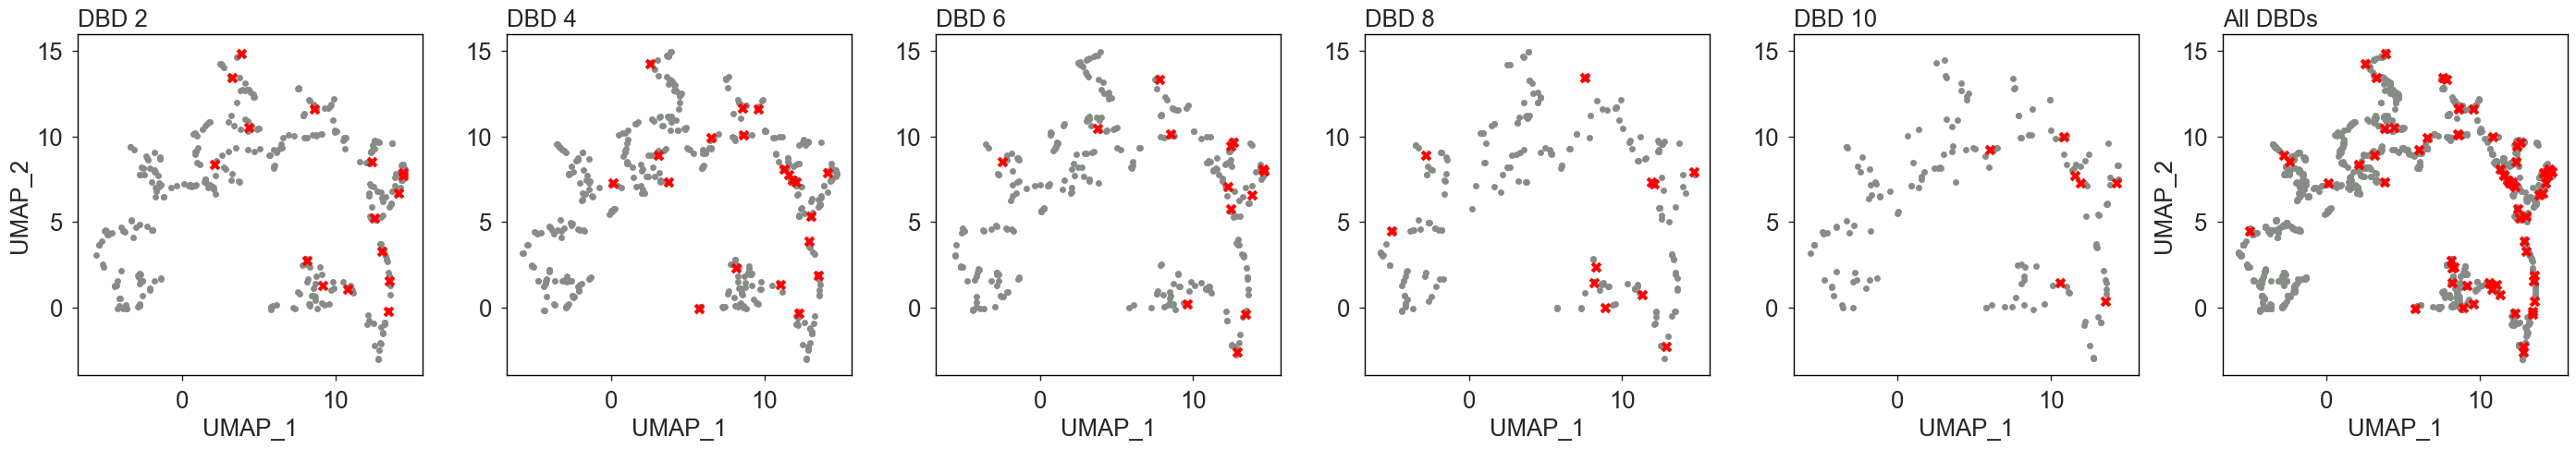

In [7]:
## Plotting the ground truth for each DBD

# dbd indicies
indices = [2, 4, 6, 8, 10]

f, axs = plt.subplots(nrows=1, ncols=6, figsize = (28, 5)) # creating the subplots
font_size = 18.5

for i, indx in enumerate(indices):
    X_dbd, y_dbd = DBD_df[df.dbd.values == indx].iloc[:, 0:6], DBD_df[df.dbd.values == indx].iloc[:, 6]

    # creating the meshgrid
    xmin, xmax = -6.8, 15.7 # setting min and max of plots -- derived from the manuscript figures
    ymin, ymax = -4, 16 # setting min and max of plots -- derived from the manuscript figures

    #### Ploting the each DBD
    mapping = dict({0: [0, 0], 1: [0, 1], 2: [0, 2], 3: [0, 3], 4: [0, 4]}) # mapping for the number of subplot
    a, b = mapping[i]
    axs[b].scatter(DBD_df[(DBD_df.dbd == indx) & (DBD_df.type == 1)].iloc[:, 8], DBD_df[(DBD_df.dbd == indx) & (DBD_df.type == 1)].iloc[:, 9], c='#878c87', s=25, edgecolor='#ffffff', linewidth=0)
    axs[b].scatter(DBD_df[(DBD_df.dbd == indx) & (DBD_df.type == 0)].iloc[:, 8], DBD_df[(DBD_df.dbd == indx) & (DBD_df.type == 0)].iloc[:, 9], c='#ff0000', s=72, edgecolor='#ffffff', linewidth=0, marker='X')
    axs[b].axis(xmin=xmin, xmax=xmax)
    axs[b].axis(ymin=ymin, ymax=ymax)
    axs[b].set_title(f'DBD {indx}', loc='left', size=font_size)
    axs[b].set_xlabel('UMAP_1', size=font_size)
    if i == 0:
        axs[b].set_ylabel('UMAP_2', size=font_size)
    axs[b].tick_params(which='major', length=4.5, width=1, labelsize=font_size)
    axs[b].xaxis.grid(None)
    axs[b].yaxis.grid(None)
    axs[b].spines[:].set_color('black')
    axs[b].spines[:].set_linewidth(1)

#### Ploting All DBDs (as a subplot)
axs[5].scatter(embedded[target == 1][:,0], embedded[target == 1][:,1], c='#878c87', s=25, edgecolor='#ffffff', linewidth=0)
axs[5].scatter(embedded[target == 0][:,0], embedded[target == 0][:,1], c='#ff0000', s=72, edgecolor='#ffffff', linewidth=0, marker='X')
axs[5].axis(xmin=xmin, xmax=xmax)
axs[5].axis(ymin=ymin, ymax=ymax)
axs[5].set_xlabel('UMAP_1', size=font_size)
axs[5].set_ylabel('UMAP_2', size=font_size)
axs[5].set_title('All DBDs', loc='left', size=font_size)
axs[5].xaxis.grid(None)
axs[5].yaxis.grid(None)
axs[5].tick_params(which='major', length=4.5, width=1, labelsize=font_size)
axs[5].spines[:].set_color('black')
axs[5].spines[:].set_linewidth(1)

f.tight_layout(pad=1)
# f.savefig("Panels_A_B.svg") # uncomment to save figure

## Classification Models with PyCaret

In [11]:
# initiating a classification model setup (NOTE: fix_imbalance = True, fix_imbalance_method = imblearn.combine.SMOTEENN())
classi_model = pyclass.setup(data = pycaret_df, target = 'type', fix_imbalance = True, fix_imbalance_method = imblearn.combine.SMOTEENN(), normalize = True,
                             create_clusters= False, session_id = 0, train_size = 0.7, fold = 10, use_gpu = False, verbose = False, silent = True)

# comparing models
best = pyclass.compare_models(n_select = 1, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6101,0.7365,0.5998,0.9859,0.7450,0.0873,0.1798,0.0090
nb,Naive Bayes,0.6241,0.7344,0.6184,0.9803,0.7578,0.0769,0.1541,0.0090
lda,Linear Discriminant Analysis,0.5989,0.7312,0.5891,0.9842,0.7363,0.0784,0.1658,0.0090
et,Extra Trees Classifier,0.7687,0.7265,0.7877,0.9632,0.8663,0.0568,0.0831,0.0530
gbc,Gradient Boosting Classifier,0.7323,0.7029,0.7398,0.9736,0.8399,0.0920,0.1489,0.0420
ada,Ada Boost Classifier,0.6801,0.7010,0.6811,0.9773,0.8009,0.0828,0.1512,0.0270
lightgbm,Light Gradient Boosting Machine,0.7678,0.7001,0.7877,0.9622,0.8659,0.0473,0.0715,0.0230
qda,Quadratic Discriminant Analysis,0.5560,0.6914,0.5499,0.9732,0.7019,0.0426,0.0974,0.0080
rf,Random Forest Classifier,0.7706,0.6892,0.7868,0.9665,0.8671,0.0780,0.1130,0.0600
knn,K Neighbors Classifier,0.6866,0.6378,0.6928,0.9705,0.8077,0.0636,0.1129,0.0170


In [12]:
# creating a logistic regression model
X,y = norm_df_PyCaret, target
model = pyclass.create_model('lr', cross_validation=True, verbose=False)

# tuning the hyperparameters with optuna
model = pyclass.tune_model(model, search_library = 'optuna', n_iter = 500, choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6204,0.6117,0.6311,0.9559,0.7602,0.0072,0.0135
1,0.6296,0.9553,0.6117,1.0000,0.7590,0.1273,0.2607
2,0.6822,0.6843,0.6863,0.9722,0.8046,0.0743,0.1288
3,0.5888,0.6647,0.5784,0.9833,0.7284,0.0758,0.1609
4,0.6636,0.8157,0.6569,0.9853,0.7882,0.1079,0.2003
5,0.6542,0.6412,0.6471,0.9851,0.7811,0.1033,0.1950
6,0.6355,0.7980,0.6176,1.0000,0.7636,0.1312,0.2649
7,0.6449,0.6294,0.6471,0.9706,0.7765,0.0584,0.1083
8,0.5888,0.8176,0.5686,1.0000,0.7250,0.1097,0.2409


### Evaluating the tuned LR model

In [13]:
pyclass.evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Panel D: Predictions of the LR model (all DBDs)

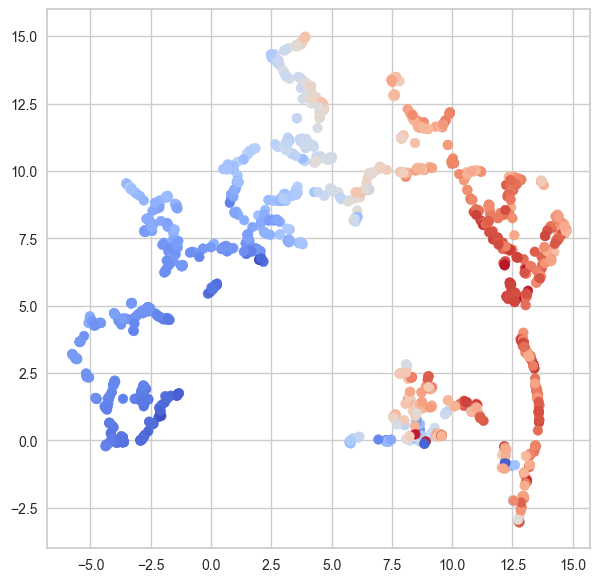

In [14]:
# fitting the tuned model
fitted_model = model.fit(X,y)

# calculating the prediction probability
y_pred = fitted_model.predict_proba(X)[:,1]

# setting the min and max of the plot
xmin, xmax = -6.8, 15.7 # setting min and max of plots -- derived from the manuscript figures
ymin, ymax = -4, 16 # setting min and max of plots -- derived from the manuscript figures

#### Ploting the UMAP with colors representing the prediction probabilities
fig = plt.figure(figsize=(7, 7))
plt.scatter(embedded[:,0], embedded[:,1], c=y_pred, cmap='coolwarm_r')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.show()

## Panel C: Predictions of the LR model (per each DBD)

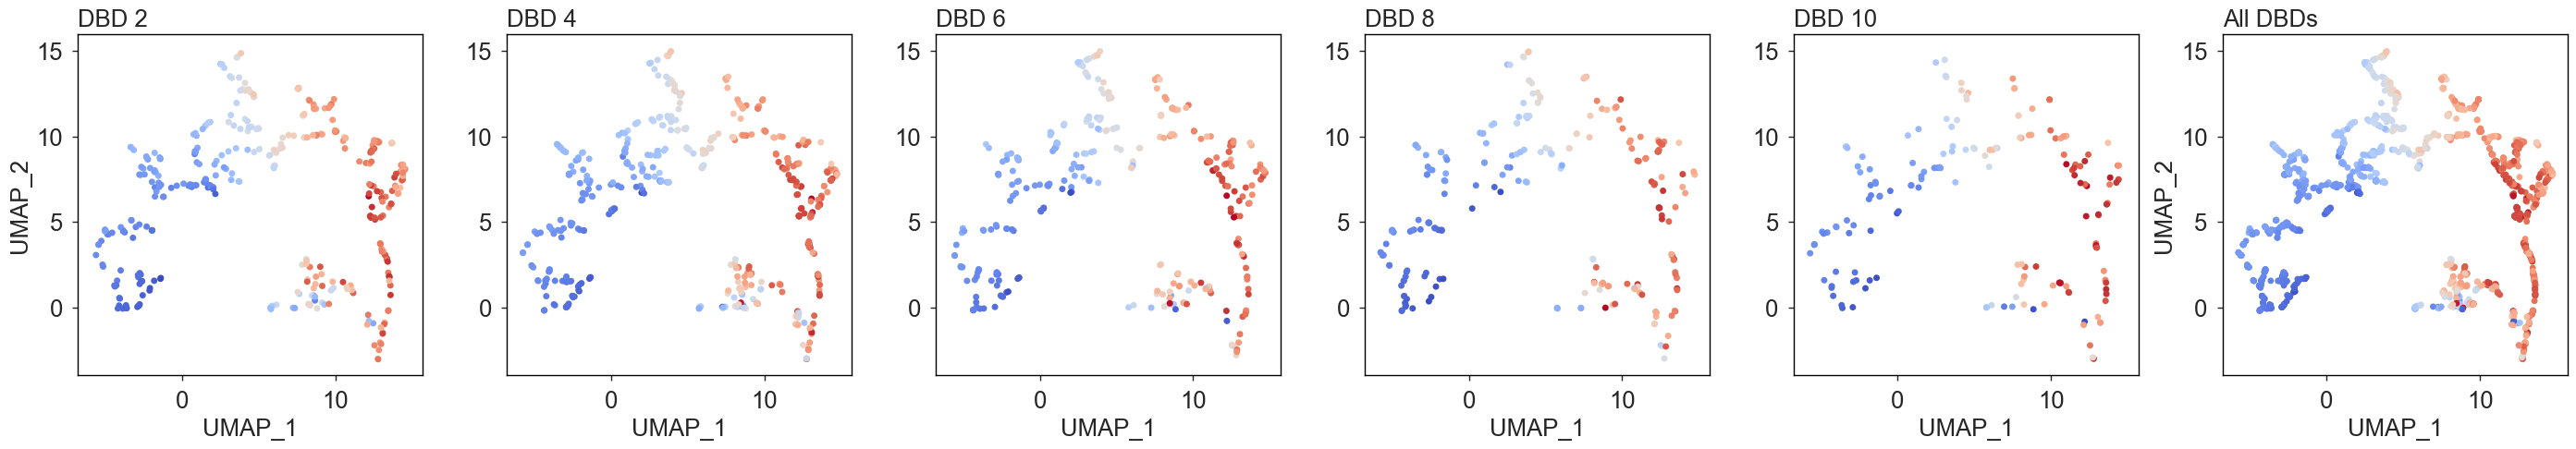

In [15]:
# dbd indicies
indices = [2, 4, 6, 8, 10]
font_size = 18.5

f, axs = plt.subplots(nrows=1, ncols=6, figsize = (28, 5)) # creating the subplots
y_pred_dbd_df = pd.DataFrame(columns=['y_pred', 'dbd', 'grouping'])

for i, indx in enumerate(indices):
    X_dbd, y_dbd = DBD_df[df.dbd.values == indx].iloc[:, 0:6], DBD_df[df.dbd.values == indx].iloc[:, 6]
    y_pred_dbd = fitted_model.predict_proba(X_dbd)[:,1]
    y_pred_dbd_df_loop = pd.DataFrame(columns=['y_pred', 'dbd', 'grouping'])
    if i < 3:
        y_pred_dbd_df_loop['y_pred'], y_pred_dbd_df_loop['dbd'], y_pred_dbd_df_loop['grouping'] = y_pred_dbd, indx, 1
    else:
        y_pred_dbd_df_loop['y_pred'], y_pred_dbd_df_loop['dbd'], y_pred_dbd_df_loop['grouping'] = y_pred_dbd, indx, 2
        
    y_pred_dbd_df = pd.concat([y_pred_dbd_df, y_pred_dbd_df_loop], axis=0, ignore_index=True)

    # creating the meshgrid
    xmin, xmax = -6.8, 15.7 # setting min and max of plots -- derived from the manuscript figures
    ymin, ymax = -4, 16 # setting min and max of plots -- derived from the manuscript figures

    #### Ploting a subplot for each DBD
    mapping = dict({0: [0, 0], 1: [0, 1], 2: [0, 2], 3: [0, 3], 4: [0, 4]}) # mapping for the number of subplot
    a, b = mapping[i]
    axs[b].scatter(DBD_df[DBD_df.dbd == indx].iloc[:, 8], DBD_df[DBD_df.dbd == indx].iloc[:, 9], c=y_pred_dbd, cmap='coolwarm_r', s=25, edgecolor='#ffffff', linewidth=0)
    axs[b].axis(xmin=xmin, xmax=xmax)
    axs[b].axis(ymin=ymin, ymax=ymax)
    axs[b].set_title(f'DBD {indx}', loc='left', size=font_size)
    axs[b].set_xlabel('UMAP_1', size=font_size)
    if i == 0:
        axs[b].set_ylabel('UMAP_2', size=font_size)
    axs[b].tick_params(which='major', length=4.5, width=1, labelsize=font_size)
    axs[b].xaxis.grid(None)
    axs[b].yaxis.grid(None)
    axs[b].spines[:].set_color('black')
    axs[b].spines[:].set_linewidth(1)

#### Ploting all DBDs together (as the last subplot)
im = plt.scatter(embedded[:,0], embedded[:,1], c=y_pred, cmap='coolwarm_r', s=24, edgecolor='#ffffff', linewidth=0)
axs[5].axis(xmin=xmin, xmax=xmax)
axs[5].axis(ymin=ymin, ymax=ymax)
axs[5].set_xlabel('UMAP_1', size=font_size)
axs[5].set_ylabel('UMAP_2', size=font_size)
axs[5].set_title('All DBDs', loc='left', size=font_size)
axs[5].xaxis.grid(None)
axs[5].yaxis.grid(None)
axs[5].tick_params(which='major', length=4.5, width=1, labelsize=font_size)
axs[5].spines[:].set_color('black')
axs[5].spines[:].set_linewidth(1)

f.tight_layout(pad=1)
# f.colorbar(im, ax=axs.ravel().tolist())
# f.savefig("Panels_C_D.svg") # uncomment to save figure

## Panels F and G: Ground truth of the most important features

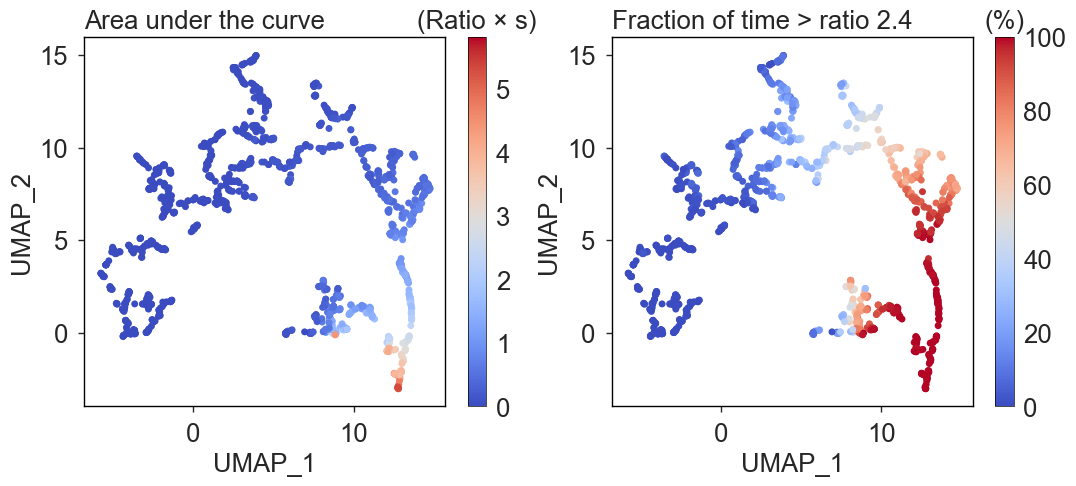

In [16]:
## Please see the feature importance in the "Evaluating the tuned LR model" section above

f_datapoints, axs_datapoints = plt.subplots(nrows=1, ncols=2, figsize = (11,5)) # creating the subplots
feature_list = ['Surviving_AUC/second', 'Surviving_Fraction of time Above 2.4']
norm_df_PyCaretpd = pd.DataFrame(norm_df_PyCaret)
MinMax_norm_df_PyCaret = norm_df_PyCaretpd.iloc[:,:].apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

# iterating over features
for i, indx in enumerate(feature_list):

    # creating the meshgrid
    xmin, xmax = -6.8, 15.7 # setting min and max of plots -- derived from the manuscript figures
    ymin, ymax = -4, 16 # setting min and max of plots -- derived from the manuscript figures

    #### Ploting the decision boundaries
    im = axs_datapoints[i].scatter(embedded[:,0], embedded[:,1], c=df.iloc[:, i+2], cmap='coolwarm', s=25, edgecolor='#ffffff', linewidth=0)
    axs_datapoints[i].axis(xmin=xmin, xmax=xmax)
    axs_datapoints[i].axis(ymin=ymin, ymax=ymax)
    if i == 0:
        axs_datapoints[i].set_title(f'Area under the curve', loc='left', size=font_size)
        colorbr = f_datapoints.colorbar(im, ax=axs_datapoints[i])
        colorbr.ax.tick_params(labelsize=font_size)
        colorbr.ax.set_title('(Ratio × s)', size=font_size)
        colorbr.outline.set_color('black')
        colorbr.outline.set_linewidth(0.5)
    else:
        axs_datapoints[i].set_title(f'Fraction of time > ratio 2.4', loc='left', size=font_size)
        colorbr = f_datapoints.colorbar(im, ax=axs_datapoints[i])
        colorbr.ax.tick_params(labelsize=font_size)
        colorbr.ax.set_title('(%)', size=font_size)
        colorbr.outline.set_color('black')
        colorbr.outline.set_linewidth(0.5)
    axs_datapoints[i].set_xlabel('UMAP_1', size=font_size)
    axs_datapoints[i].set_ylabel('UMAP_2', size=font_size)
    axs_datapoints[i].tick_params(which='major', length=4.5, width=1, labelsize=font_size)
    axs_datapoints[i].xaxis.grid(None)
    axs_datapoints[i].yaxis.grid(None)
    axs_datapoints[i].spines[:].set_color('black')
    axs_datapoints[i].spines[:].set_linewidth(1)

f_datapoints.tight_layout(pad=1)
# f_datapoints.savefig("Panels_F_G.svg") # uncomment to save figure